# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [241]:
from skimage.draw import circle
from scipy.ndimage.filters import laplace

# Simulate

In [247]:
def show_pattern(ax, space, color=plt.cm.Greys_r):
    ax.imshow(space, cmap=color, interpolation='bilinear', extent=[-1,1,-1,1])
    ax.set_axis_off()

## FitzHugh-Nagamo Equation

\begin{align*}
\frac{\partial u}{\partial t} &= a \Delta u + u - u^3 - v + k\\
\tau\frac{\partial v}{\partial t} &= b \Delta v + u - v
\end{align*}

In [49]:
def laplacian(space, dspace):
    # (x,y) in space with truncated edges (boundaries not correct)
    space_top = space[0:-2, 1:-1] # u(x, y+h)
    space_bottom = space[2:, 1:-1] # u(x, y-h)
    space_left = space[1:-1, 0:-2] # u(x-h, y)
    space_right = space[1:-1, 2:] # u(x+h, y)
    space_center = space[1:-1, 1:-1] # u(x,y)
    return (space_top + space_bottom + space_left + space_right - 4*space_center)/dspace**2

In [173]:
# Discretize time and space
size = 100 # size by size, 2D grid
dx = 2/size
T = 9 # total time
dt = .001
n = int(T/dt) # Number of iterations

In [172]:
# Define parameters
a = 2.8e-5 # Diffusion favoring skin pigmentation
b = 5e-3 # Diffusion impeding skin pigmentation
tau = .1
k = -0.005

$\Delta u(x,y) \simeq \frac{u(x+h,y)+u(x-h,y)+u(x,y+h)+u(x,y-h)-4u(x,y)}{dx^2}$

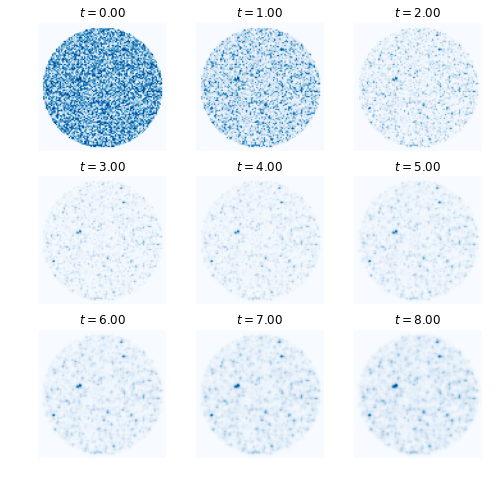

In [186]:
fig, ax = plt.subplots(3,3,figsize=(8,8))
step_plot = n//9 # evenly divide iterations into 9 steps

img = np.zeros((size, size), dtype=np.bool)
rr, cc = circle(size//2, size//2, size//2)
img[rr, cc] = 1
U = np.random.rand(size, size)
U[~img] = 1

V = np.random.rand(size, size)

# simulate using finite differences
for i in range(n):
    # compute laplacian of u and v
    delta_U = laplacian(U, dx)
    delta_V = laplacian(V, dx)
    
    # take inside of grid (boundaries later)
    Uc = U[1:-1, 1:-1]
    Vc = V[1:-1, 1:-1]
    
    # update
    U[1:-1, 1:-1] += dt*(a*delta_U + Uc - Uc**3)
    V[1:-1, 1:-1] += dt*(b*delta_V + Uc - Vc)/tau
    
    # fix boundaries using Von Neumann condition (derivative at edge = 0)
    for Z in (U, V):
        Z[0,:] = Z[1,:]
        Z[-1,:] = Z[-2,:]
        Z[:,0] = Z[:,1]
        Z[:,-1] = Z[:,-2]
        
    # extract 9 times
    if i % step_plot == 0 and i < 9 * step_plot:
        iax = ax.flat[i // step_plot]
        show_pattern(iax, U)
        iax.set_title(f'$t={i*dt:.2f}$')

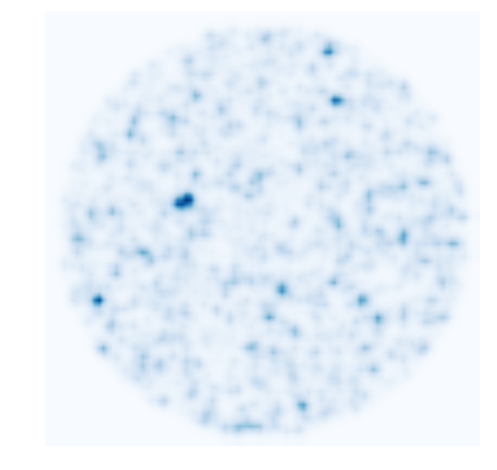

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
show_pattern(ax, U)

## Gray-Scott Equation

### Code

In [398]:
class gray_scott:
    def __init__(self, time, dt, params):
        ''' Model the Gray-Scott reaction diffusion equations.

        Parameters
            time: total time
            dt: time step
            params{}:
                'a': diffusion of U
                'b': diffusion of V
                'feed': feed rate of U
                'kill': feed rate of V
        '''
        self.time = time
        self.dt = dt
        self.iterations = int(time/dt)
        self.a = params['a']
        self.b = params['b']          
        self.k = params['kill']          
        self.f = params['feed']          
            
    def simulate(self, initial):
        U = np.ones_like(initial)
        V = initial

        # Simulate using finite differences
        for i in range(self.iterations):
            # compute laplacian of u and v
            delta_U = laplace(U, mode='wrap')
            delta_V = laplace(V, mode='wrap')

            # update
            U += dt*(self.a*delta_U - U*V**2 + self.f*(1-U))
            V += dt*(self.b*delta_V + U*V**2 - (self.k + self.f)*V)

            # extract
            yield V
            
    def simulate_and_show(self, initial, ax):
        size = len(ax.flatten()) 
        step_plot = self.iterations//size # evenly divide iterations by axis size
        for i, V in enumerate(self.simulate(initial)):
            if i % step_plot == 0 and i//step_plot < size:
                iax = ax.flat[i // step_plot]
                show_pattern(iax, V, color=plt.cm.Blues)
                iax.set_title(f'$t={i*dt:.2f}$')

### Examples

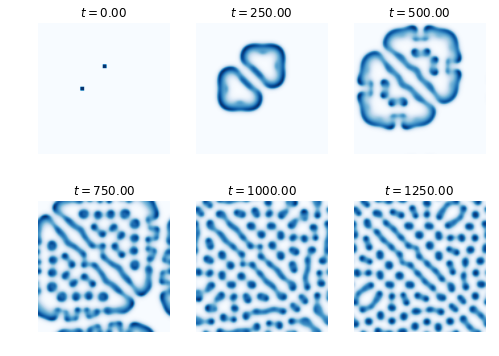

In [378]:
model_params = {
    'a': 1,
    'b': 0.1,
    'feed': 0.055,
    'kill': 0.062
}
gs = gray_scott(1500, 0.1, model_params)

size = 100
initial = np.zeros((size,size))
rr, cc = circle(size//2, size//3, 2)
initial[rr, cc] = 1
rr, cc = circle(size//3, size//2, 2)
initial[rr, cc] = 1

fig, ax = plt.subplots(2,3,figsize=(8,6))
gs.simulate_and_show(initial, ax)

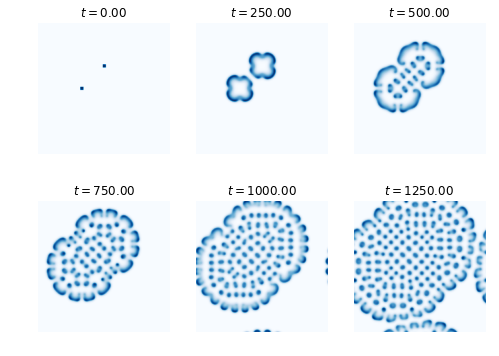

In [427]:
model_params = {
    'a': 1,
    'b': 0.1,
    'feed': 0.026,
    'kill': 0.055
}
gs = gray_scott(1500, 0.1, model_params)

size = 200
initial = np.zeros((size, size))
rr, cc = circle(size//2, size//3, 3)
initial[rr, cc] = 1
rr, cc = circle(size//3, size//2, 3)
initial[rr, cc] = 1

fig, ax = plt.subplots(2,3,figsize=(8,6))
gs.simulate_and_show(initial, ax)

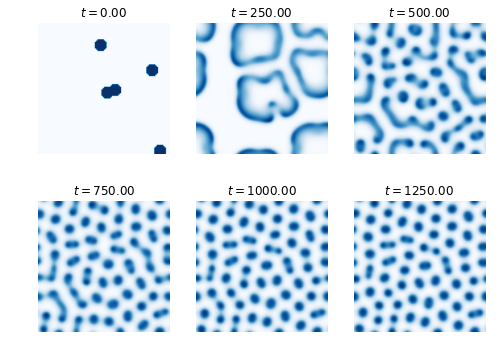

In [426]:
model_params = {
    'a': 1,
    'b': 0.1,
    'feed': 0.026,
    'kill': 0.053,
}
gs = gray_scott(1500, 0.1, model_params)

size = 100
initial = np.zeros((size, size))
pts = 5
for x,y in zip(np.random.randint(0, size-1, pts), np.random.randint(0, size-1, pts)):
    rr, cc = circle(x, y, 5, shape=(size,size))
    initial[rr, cc] = 1

fig, ax = plt.subplots(2,3,figsize=(8,6))
gs.simulate_and_show(initial, ax)

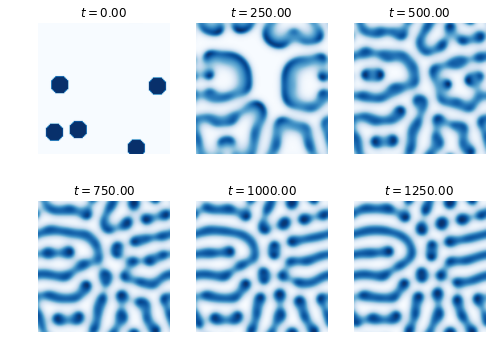

In [425]:
model_params = {
    'a': 1,
    'b': 0.2,
    'feed': 0.04,
    'kill': 0.06,
}
gs = gray_scott(1500, 0.1, model_params)

size = 100
initial = np.zeros((size, size))
pts = 5
for x,y in zip(np.random.randint(0, size-1, pts), np.random.randint(0, size-1, pts)):
    rr, cc = circle(x, y, 7, shape=(size,size))
    initial[rr, cc] = 1

fig, ax = plt.subplots(2,3,figsize=(8,6))
gs.simulate_and_show(initial, ax)

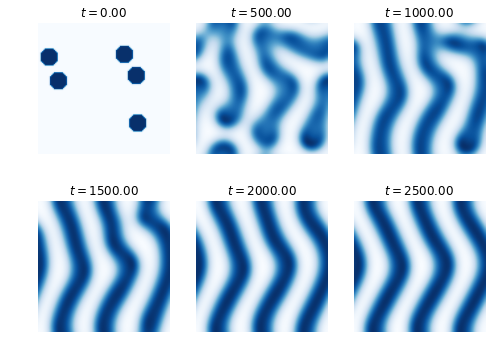

In [428]:
model_params = {
    'a': 1,
    'b': 0.5,
    'feed': 0.034,
    'kill': 0.059,
}
gs = gray_scott(3000, 0.1, model_params)

size = 100
initial = np.zeros((size, size))
pts = 5
for x,y in zip(np.random.randint(0, size-1, pts), np.random.randint(0, size-1, pts)):
    rr, cc = circle(x, y, 7, shape=(size,size))
    initial[rr, cc] = 1

fig, ax = plt.subplots(2,3,figsize=(8,6))
gs.simulate_and_show(initial, ax)

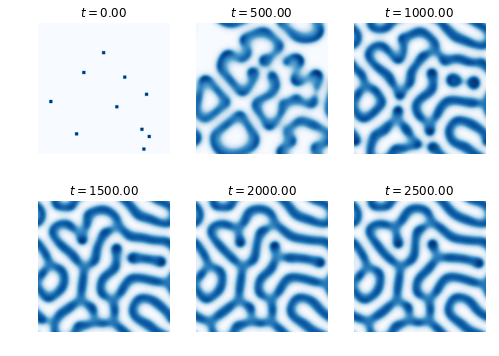

In [431]:
model_params = {
    'a': 1,
    'b': 0.5,
    'feed': 0.034,
    'kill': 0.059,
}
gs = gray_scott(3000, 0.1, model_params)

size = 200
initial = np.zeros((size, size))
pts = 10
for x,y in zip(np.random.randint(0, size-1, pts), np.random.randint(0, size-1, pts)):
    rr, cc = circle(x, y, 3, shape=(size,size))
    initial[rr, cc] = 1

fig, ax = plt.subplots(2,3,figsize=(8,6))
gs.simulate_and_show(initial, ax)